In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda:0')

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load MNIST Dataset

In [2]:
# for training set, we load the data and label
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True)
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()

# for test set, we load the data and label
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True)
xtest = testset.data.numpy()
ytest = testset.targets.numpy()

print (xtrain.shape, ytrain.shape)
print (xtest.shape, ytest.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630836880/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### get data loader

In [3]:
# transform pixel value (0, 255) into {0,1}
xtrain = np.where(xtrain > 128, 1, 0)
xtrain = xtrain.astype(np.float32)

# transform pixel value (0, 255) into {0,1}
xtest = np.where(xtest > 128, 1, 0)
xtest = xtest.astype(np.float32)

batch_size = 512
trainloader = torch.utils.data.DataLoader([[xtrain[i], ytrain[i]] for i in range(len(ytrain))], \
                                          shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[xtest[i], ytest[i]] for i in range(len(ytest))], \
                                         shuffle=False, batch_size=batch_size)

# sigma is the noise std
sigma = 0.35

## 2. Define the Diffusion Model

In [4]:
class Diffuser(nn.Module):
    def __init__(self, diff_steps, n_labels):
        super(Diffuser, self).__init__()

        self.diffusion = nn.Sequential(
            nn.Linear(28*28 + diff_steps + n_labels, 28*28),
            nn.ReLU(),
            nn.Linear(28*28, 28*28),
        )
        
        self.diff_steps = diff_steps
        self.n_labels = n_labels

    def forward(self, x, step, label):
        
        # one hot for diffusion step
        step_encoding = F.one_hot(
            torch.tensor([step]*x.shape[0]), num_classes = self.diff_steps
        ).to(device)
        
        # one hot for label
        labels_encoding = F.one_hot(label, num_classes = self.n_labels).to(device)
        
        # concat features and run diffusion process
        emb = torch.cat([x, step_encoding, labels_encoding], 1)
        out = self.diffusion(emb)
    
        # normalize the output
        MEAN = out.mean(dim=1, keepdim=True)
        STD = out.std(dim=1, keepdim=True) + 1e-8
        out = (out - MEAN) / STD * sigma
        return out
    
diffusion_steps = 25
model = Diffuser(25, 10)
model.to(device) # move model to GPU

Diffuser(
  (diffusion): Sequential(
    (0): Linear(in_features=819, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=784, bias=True)
  )
)

## 3. Model Training and Evaluation

In [5]:
# normal distribution sampler (we could throw to cuda for once)
unit_normal = torch.distributions.Normal(0, sigma)
unit_normal.loc = unit_normal.loc.to(device)
unit_normal.scale = unit_normal.scale.to(device)

### show a diffusion process demo

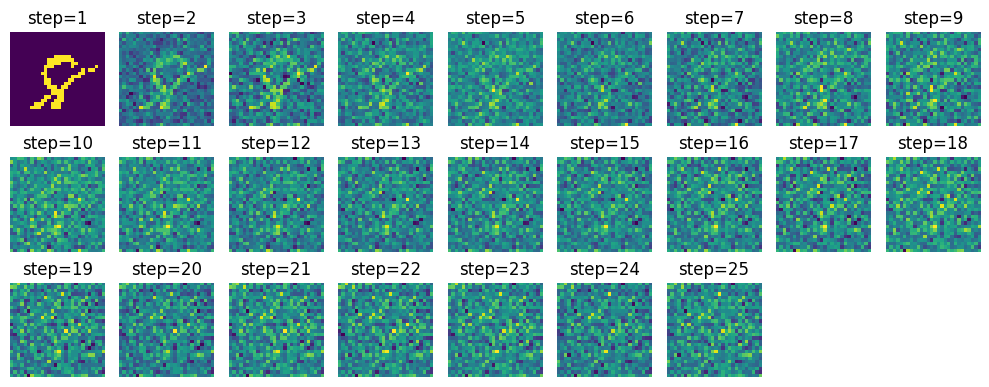

In [6]:
# demo: diffusion process
images, labels = next(iter(trainloader))
image = images[0]
label = labels[0]

plt.figure(figsize=(10, 4))
for i in range(diffusion_steps):
    plt.subplot(3, 9, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"step={i+1}")
    
    # Draw noise from a normal distribution
    noise = unit_normal.sample(image.shape).cpu()
    # Add the noise to the image
    image += noise
    
plt.tight_layout()

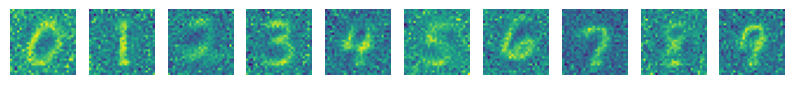

In [11]:
def evaluate(model, diffusion_steps):
    
    # 0, 1, ..., 9
    labels = torch.arange(10)
    
    # random images
    noisy_images = unit_normal.sample((len(labels),28,28)) * np.sqrt(diffusion_steps)
    
    plt.figure(figsize=(10, 5))
    
    # we run diffusion process for multiple steps
    # to denoise the noisy images into a digit image
    for diffusion_step in range(diffusion_steps):    
        step = diffusion_steps - diffusion_step - 1
        with torch.no_grad():
            noise = model(noisy_images.view(10, 28*28), step, labels)
        noisy_images -= noise.view(len(labels), 28, 28)

    for i in range(10):
        plt.subplot(1, 10, i+1)
        # print the digit one by one
        plt.imshow(noisy_images[i].cpu())
        plt.axis('off')
    plt.show()

evaluate(model, diffusion_steps)

100%|███████████████████████████████████████████████████████████████████████████████| 118/118 [00:06<00:00, 18.14it/s]


Epoch: 0 	 Loss: 489.2960710581392


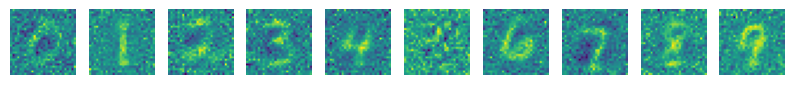

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 0.1)
criterion = nn.MSELoss()


for epoch in range(1):
    epoch_loss = 0
    for images, labels in tqdm(trainloader):
        images = images.to(device).view(-1, 28*28)

        for step in torch.randperm(diffusion_steps):
            # get a sample at step: original image + sqrt(step) * normal sample
            less_noisy = images + unit_normal.sample(images.shape) * np.sqrt(step)
            # get a normal sample
            one_step_noise = unit_normal.sample(images.shape)
            # get the sample at (step + 1)
            more_noisy = less_noisy + one_step_noise 
        
            output = model(more_noisy, step, labels)
            loss = criterion(output, one_step_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

            epoch_loss += loss.item()
    print(f'Epoch: {epoch} \t Loss: {epoch_loss}')
    
    if epoch % 5 == 0:
        evaluate(model, diffusion_steps)